# Single-view Reconstruction

This example shows the use of cloudy to generate a cloud from a single image. The forward model considers a physically-based volume differentiable renderer $y=\mathcal{R}(\hat{x}) + \epsilon$. In this case, all parameters refering to physical properties ar known, only the volume $\hat{x}$ densities is unknown.

In [1]:
try:  # install all dependencies in colab 
    import google.colab
    !sudo apt-get update -y
    !sudo apt-get install -y libnvidia-gl-555 vulkan-tools glslang-tools vulkan-validationlayers-dev
    !pip install git+https: // github.com/rendervous/cloudy_project.git
except:
    print("Executing locally")

Executing locally


Similarly to previous tutorials, we will import required modules and load a reference volume.

/home/leonard/rendervous.project/rdv_env/lib/python3.10/site-packages/torch/_utils.py:831: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  return self.fget.__get__(instance, owner)()
Rendering captures: 100%|██████████| 1/1 [00:01<00:00,  1.22s/it]


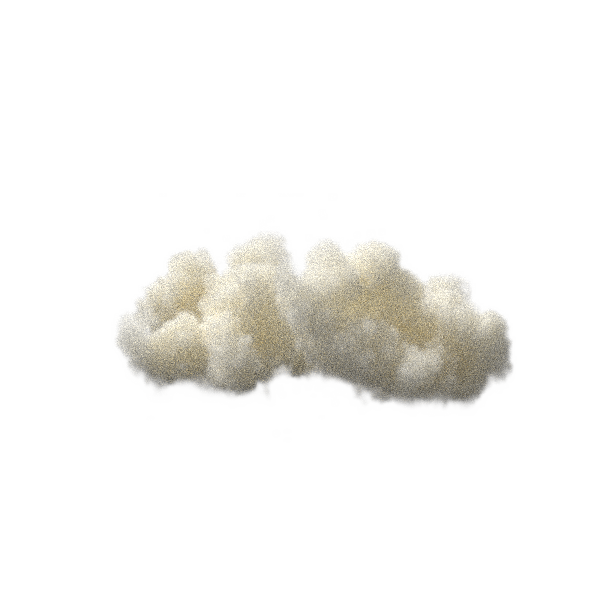

In [2]:
import cloudy
import torch
import numpy as np
import vulky.datasets as datasets  # module containing some resources for examples.
import os
import matplotlib.pyplot as plt


pipeline = cloudy.create_pipeline('./test')
pipeline.download_pretrained()  # Comment if it is already downloaded
recorder = pipeline.create_recorder()
ref_latent = pipeline.get_test_latent(8)
ref_grid = pipeline.decode_latent(ref_latent)
ref_grid = pipeline.clean_volume(ref_grid)
recorder.new_keyframe(recorder.add_capture_volume(ref_grid, samples=32))
recorder.show_clip(1)

There are several methods in **cloudy** to synthesize photo-realistic images from densities, environment maps and other physical properties related to the participating medium such as scattering albedo and phase function ($g$ value of the Henyey-Greenstein approximation). The method `scattered` compute the radiance, and it is differentiable wrt to the extinction field $\sigma_t$ (densities).

Next, we will define the settings will be considered as known.

In [3]:
settings = dict(
    camera_position = (np.cos(0.5) * 2.7, np.sin(0.5), np.sin(0.5) * 2.7),
    environment = datasets.Images.environment_example.to('cuda'),  # An HDR environment
    density_scale = 300,
    phase_g = 0.0,
    scattering_albedo = (0.99, 0.98, 0.94),
)

The environment mapping will be used is an equirectangular projection. With an HDR image, we can create the models for environment and environment sampler as follows. Those maps are part of **rendervous** and used to sample a direction wrt to environment contribution and the radiance itself.

In [4]:
environment, environment_sampler = cloudy.environment_objects(settings['environment'])

With this, only the density distribution is needed. A rendering function could be like:

In [5]:
def render_grid(g: torch.Tensor, samples: int = 128):
    return cloudy.scattered(g * settings['density_scale'],
                     camera_poses=cloudy.camera_poses(settings['camera_position']),
                     scattering_albedo=settings['scattering_albedo'],
                     environment=environment,
                     environment_sampler=environment_sampler,
                     phase_g=settings['phase_g'],
                     majorant=g.max() * settings['density_scale'],
                     # kwargs
                     width=512,  # image width in pixels
                     height=512,  # image height in pixels
                     jittered=True,  # rays pass through 
                     samples=samples,  # number of ray paths for the primal evaluation
                     samples_bw=8,  # number of ray paths for the gradients backprop
                     mode='sps'  # singular path-sampling is used instead of DRT.
                     )

Next, let's create a reference image with sufficient samples to remove noise. The accumulation of several calls to `render_grid` is to avoid TDR to trigger device lost.

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Loading cached reference_image.pt


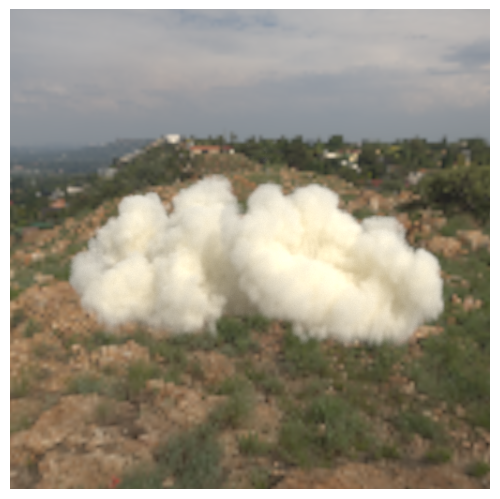

In [6]:
with torch.no_grad():
    # Generate reference image
    if os.path.exists('./reference_image.pt'):
        print("Loading cached reference_image.pt")
        reference_image = torch.load('./reference_image.pt', map_location='cuda', weights_only=True)
    else:
        reference_image = cloudy.accumulate(lambda: render_grid(ref_grid), times=8)
        torch.save(reference_image, './reference_image.pt')

plt.imshow(reference_image[0].cpu() ** (1.0/2.2))
plt.gca().invert_yaxis()
plt.gca().axis('off')
plt.tight_layout(pad=0.0)
plt.show()

Next, we will perform a posterior sampling conditioned to the reference image. The `ema_factor` plays an important role. It represents an Exponential Moving Average factor for the estimation $\mathcal{R}(\hat{x})$. The stochastic nature of $\mathcal{R}$ affects the gradients and the variance reduction helps to mitigate the bias introduced to the estimation of $\partial \mathcal{L} / \partial \hat{x}$.   

In [7]:
grid = pipeline.sample_volume(
    resolution=128,
    samples=200,
    scheduler_gamma=0.6,
    y=reference_image,
    A=lambda v: render_grid(v, samples=32),
    ema_factor=0.3,
)

Non-A100 GPU detected, using math or mem efficient attention if input tensor is on cuda


Posterior sampling DPS_DDIM: 100%|██████████| 200/200 [03:51<00:00,  1.16s/it]


Let's generate different rotated views starting from target camera pose.

Rendering captures: 100%|██████████| 8/8 [00:07<00:00,  1.00it/s]


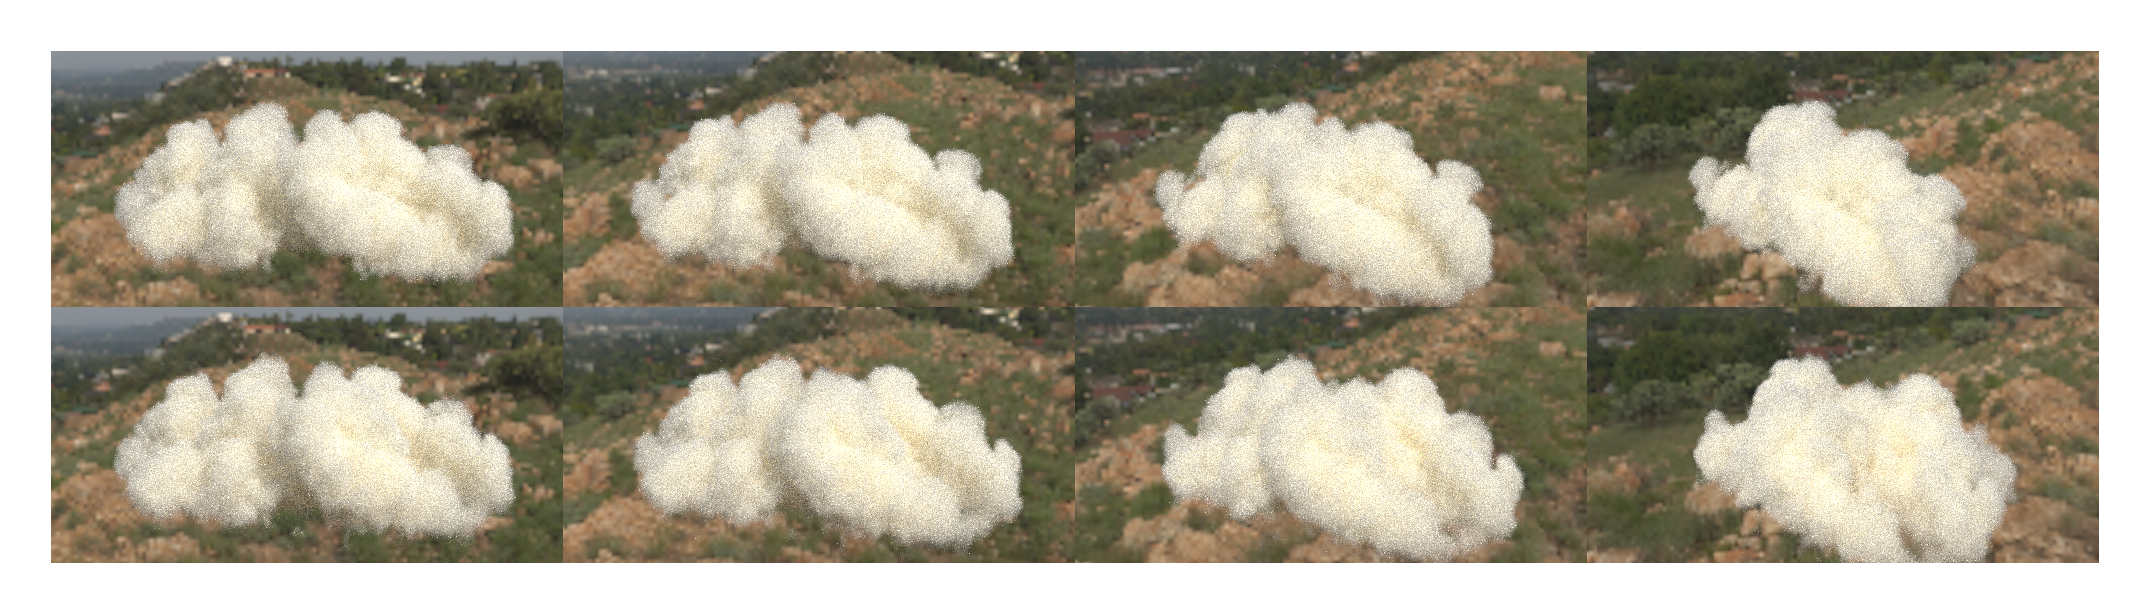

In [8]:
# create a recorder for the transitions
recorder = pipeline.create_recorder()
# saves the grid in the recorder to be used several times
ref_grid_id = recorder.add_volume(ref_grid)
grid_id = recorder.add_volume(grid)
# saves the environment tensor
env_id = recorder.add_environment(settings['environment'])
# capture multiple camera poses
for i in range(4):
    alpha = (i/4)**1.5
    recorder.new_keyframe(
        # Novel view for the reference grid
        recorder.add_capture_volume(ref_grid_id,
                                    environment=env_id,
                                    camera_position=(np.cos(0.5 + alpha)*2.7, np.sin(0.5 + alpha), np.sin(0.5 + alpha)*2.7),
                                    scattering_albedo=settings['scattering_albedo'],
                                    phase_g=settings['phase_g'],
                                    density_scale=settings['density_scale'],
                                    samples=32, render_mode='ms'),
        # Novel view for the sampled grid
        recorder.add_capture_volume(grid_id,
                                    environment=env_id,
                                    camera_position=(np.cos(0.5 + alpha)*2.7, np.sin(0.5 + alpha), np.sin(0.5 + alpha)*2.7),
                                    scattering_albedo=settings['scattering_albedo'],
                                    phase_g=settings['phase_g'],
                                    density_scale=settings['density_scale'],
                                    samples=32, render_mode='ms')        
    )
recorder.show_clip(4)

While the same camera pose matches acceptably, the novel views show that the volume is not constrained sufficiently but preserves a cloudy appearance. The ambiguity in the reconstruction can be also evidenced for the camera pose of reference by relighting.

Rendering captures: 100%|██████████| 2/2 [00:01<00:00,  1.21it/s]


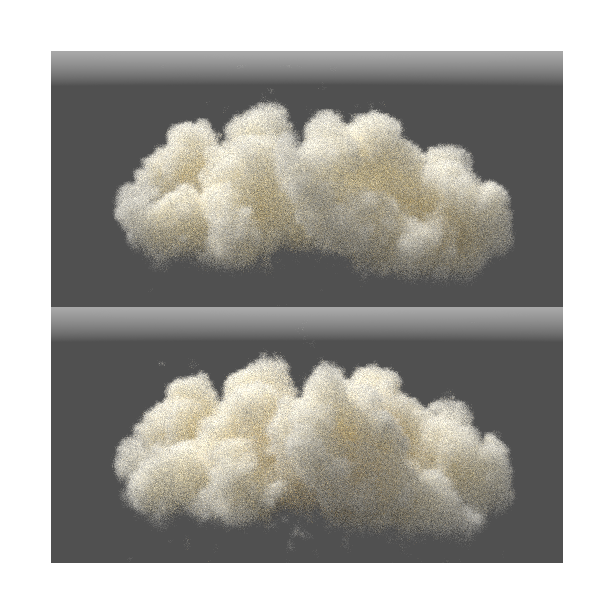

In [9]:
# create a recorder for the transitions
recorder = pipeline.create_recorder()
# capture multiple camera poses
recorder.new_keyframe(
    # Novel view for the reference grid
    recorder.add_capture_volume(ref_grid,
                                # default environment used
                                camera_position=settings['camera_position'],
                                scattering_albedo=settings['scattering_albedo'],
                                phase_g=settings['phase_g'],
                                density_scale=settings['density_scale'],
                                samples=32, render_mode='ms'),
    # Novel view for the sampled grid
    recorder.add_capture_volume(grid,
                                # default environment used
                                camera_position=settings['camera_position'],
                                scattering_albedo=settings['scattering_albedo'],
                                phase_g=settings['phase_g'],
                                density_scale=settings['density_scale'],
                                samples=32, render_mode='ms')        
)
recorder.show_clip(1)